The entire code section consist of following number of notebook.

- Synthetic Data Generation
- __Dataset Preparation__
- Model UNet
- integrated Application

## 02 : Dataset Preparation

In [1]:
bRAW = True
bROI = False

In [2]:
# Run this section only if it is from Colab
# this will mount the gdrive, where all the datasets are saved

inColab = 'google.colab' in str(get_ipython())
if inColab:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# declare all the PyTorch packages
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

# Package to handle image
from PIL import Image
import imageio

import os
import glob
import time
import random
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Function definitions

In [4]:
def createDir(path):
    '''
    Function to check the presence of a folder,
    if not it will create that folder
    '''
    directory = path.split('/')[-1]
    if not os.path.isdir(path):
        # os.makedirs(path)
        try:
            os.makedirs(path, exist_ok = True)
            print("Directory '%s' created successfully" %directory)
        except OSError as error:
            print("Directory '%s' can not be created")
    else:
        print("Directory '%s' already exist" %directory)

    return None

In [5]:
def torch_display2(i, img_links, mask_links):
    '''
    function to display 2 images, index number and list for both
    images and mask are provided.
    param:
        i - index number
        img_links - images list in tensor
        mask_links - masks list in tensor
    '''

    img = torch.load(img_links[i])
    mask = torch.load(mask_links[i])

    f, axarr = plt.subplots(1,2, figsize=(15,15))
    axarr[0].imshow(img.permute(1,2,0).detach().numpy())
    axarr[1].imshow(mask.permute(1,2,0).detach().numpy())
    plt.show()

### Variable Initialization

In [7]:
# Hyperparameters for deep learning

# size of the input image for training
# 512 x 512 for raw images (dl alone)
# 256 x 256 for roi images (hybrid)


raw_HEIGHT = 512
raw_WIDTH  = 512

roi_HEIGHT = 256
roi_WIDTH  = 256

In [8]:
# Specify paths to your files
# (glob stores paths to all files in a folder in a list)

# Specify path for project root folder
# for local system
root = ''
# for colab
if inColab:
  root = '/content/drive/MyDrive/P1_source/'

# directory of training dataset from root of project
sub_dir = 'dataset/sd_2/sd2_roi/'
if bRAW:
    sub_dir = 'dataset/sd_2/sd2_raw/'

# Get the list of all the images from train and mask folder and sort it
train_img_link_list  = sorted(glob.glob(root + sub_dir + 'train/*.jpg'))
train_mask_link_list = sorted(glob.glob(root + sub_dir + 'mask/*.png'))

# root = os.getcwd()
# train_img_link_list  = sorted(glob.glob(root + '/data/train_images/*'))
# train_mask_link_list = sorted(glob.glob(root + '/data/train_masks/*'))
# test_img_link_list   = sorted(glob.glob(root + '/data/test_images/*'))

print('No. of image :',len(train_img_link_list))
print('No. of mask :', len(train_mask_link_list))

No. of image : 240
No. of mask : 240


In [9]:
train_img_link_list[:10], train_mask_link_list[:10]

(['/content/drive/MyDrive/P1_source/dataset/sd_2/sd2_raw/train/sd2_001.jpg',
  '/content/drive/MyDrive/P1_source/dataset/sd_2/sd2_raw/train/sd2_002.jpg',
  '/content/drive/MyDrive/P1_source/dataset/sd_2/sd2_raw/train/sd2_003.jpg',
  '/content/drive/MyDrive/P1_source/dataset/sd_2/sd2_raw/train/sd2_004.jpg',
  '/content/drive/MyDrive/P1_source/dataset/sd_2/sd2_raw/train/sd2_005.jpg',
  '/content/drive/MyDrive/P1_source/dataset/sd_2/sd2_raw/train/sd2_006.jpg',
  '/content/drive/MyDrive/P1_source/dataset/sd_2/sd2_raw/train/sd2_007.jpg',
  '/content/drive/MyDrive/P1_source/dataset/sd_2/sd2_raw/train/sd2_008.jpg',
  '/content/drive/MyDrive/P1_source/dataset/sd_2/sd2_raw/train/sd2_009.jpg',
  '/content/drive/MyDrive/P1_source/dataset/sd_2/sd2_raw/train/sd2_010.jpg'],
 ['/content/drive/MyDrive/P1_source/dataset/sd_2/sd2_raw/mask/sd2_001.png',
  '/content/drive/MyDrive/P1_source/dataset/sd_2/sd2_raw/mask/sd2_002.png',
  '/content/drive/MyDrive/P1_source/dataset/sd_2/sd2_raw/mask/sd2_003.png',
 

In [10]:
splitter = '\\'
if inColab:
    splitter = '/' # for colab

# Get only the names of each image with out extension
file_names = []
for i in range(len(train_img_link_list)):
    file_names.append(train_img_link_list[i].split(splitter)[-1].split('.')[0])

# Get last few selected images for validation
val_img_list = file_names[-40:]

print('No. of validation images : ',len(val_img_list))

No. of validation images :  40


In [11]:
# Testing block to cross check the files names
i = 0
img_id  = train_img_link_list[i].split(splitter)[-1].split('.')[0]
mask_id = train_mask_link_list[i].split(splitter)[-1].split('.')[0]
print(img_id, mask_id)

sd2_001 sd2_001


### Create the directory structure to store the tensor data

In [ ]:
# root + sub_dir

In [13]:
# Create a tensor folder if not created
mypath = root + sub_dir + f'tensor'
createDir(mypath)

HEIGHT = roi_HEIGHT
WIDTH = roi_WIDTH
if bRAW:
    HEIGHT = raw_HEIGHT
    WIDTH = raw_WIDTH

# Create a validation and train image and mask folder if not created
mypath = root + sub_dir + f'tensor/val_images_{HEIGHT}'
createDir(mypath)

mypath = root + sub_dir + f'tensor/val_masks_{HEIGHT}'
createDir(mypath)

mypath = root + sub_dir + f'tensor/train_images_{HEIGHT}'
createDir(mypath)

mypath = root + sub_dir + f'tensor/train_masks_{HEIGHT}'
createDir(mypath)

Directory 'tensor' already exist
Directory 'val_images_512' already exist
Directory 'val_masks_512' already exist
Directory 'train_images_512' already exist
Directory 'train_masks_512' already exist


### Convert image to tensor

In [14]:
# Validation data in string format
val_img_list = [str(x) for x in val_img_list]

# Transformation pipeline
transform_img = transforms.Compose([
    transforms.Resize([HEIGHT,WIDTH]),
    transforms.ToTensor()
])

transform_mask = transforms.Compose([
    # transforms.Resize([HEIGHT,WIDTH], interpolation=Image.NEAREST),
    transforms.Resize([HEIGHT,WIDTH], interpolation=T.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

transform_mask_prova = transforms.Compose([
    transforms.ToTensor()
])

# Iterate through all masks and images in train set,
# transform them and store corresponging tensors in a folder
for i in tqdm(range(len(train_img_link_list))):
    # Get the file name and compare whether image and mask matches
    img_id  = train_img_link_list[i].split(splitter)[-1].split('.')[0]
    mask_id = train_mask_link_list[i].split(splitter)[-1].split('.')[0]
    assert img_id == mask_id    # Make sure id's match

    # Open the both the image file
    img   = Image.open(train_img_link_list[i])
    mask  = Image.open(train_mask_link_list[i])

    # Transform and convert into tensor
    img  = transform_img(img)
    mask = transform_mask(mask)*255
    mask = mask.int()

    # check if image is from train or validation list
    # and save it to corresponding folder
    if img_id in val_img_list:
        torch.save(img, root + sub_dir + f'tensor/val_images_{HEIGHT}/{img_id}.pt')
        torch.save(mask, root+ sub_dir + f'tensor/val_masks_{HEIGHT}/{mask_id}.pt')
    else:
        torch.save(img, root + sub_dir + f'tensor/train_images_{HEIGHT}/{img_id}.pt')
        torch.save(mask, root+ sub_dir + f'tensor/train_masks_{HEIGHT}/{mask_id}.pt')

print('Train and Validation sets created')

100%|██████████| 240/240 [04:50<00:00,  1.21s/it]

Train and Validation sets created


### Testing the tensor (visualization)

In [15]:
# Get all the files into a list

tra_img_tensor_list  = sorted(glob.glob(root + sub_dir + f'/tensor/train_images_{HEIGHT}/*'))
tra_mask_tensor_list = sorted(glob.glob(root + sub_dir + f'/tensor/train_masks_{HEIGHT}/*'))
val_img_tensor_list  = sorted(glob.glob(root + sub_dir + f'/tensor/val_images_{HEIGHT}/*'))
val_mask_tensor_list = sorted(glob.glob(root + sub_dir + f'/tensor/val_masks_{HEIGHT}/*'))

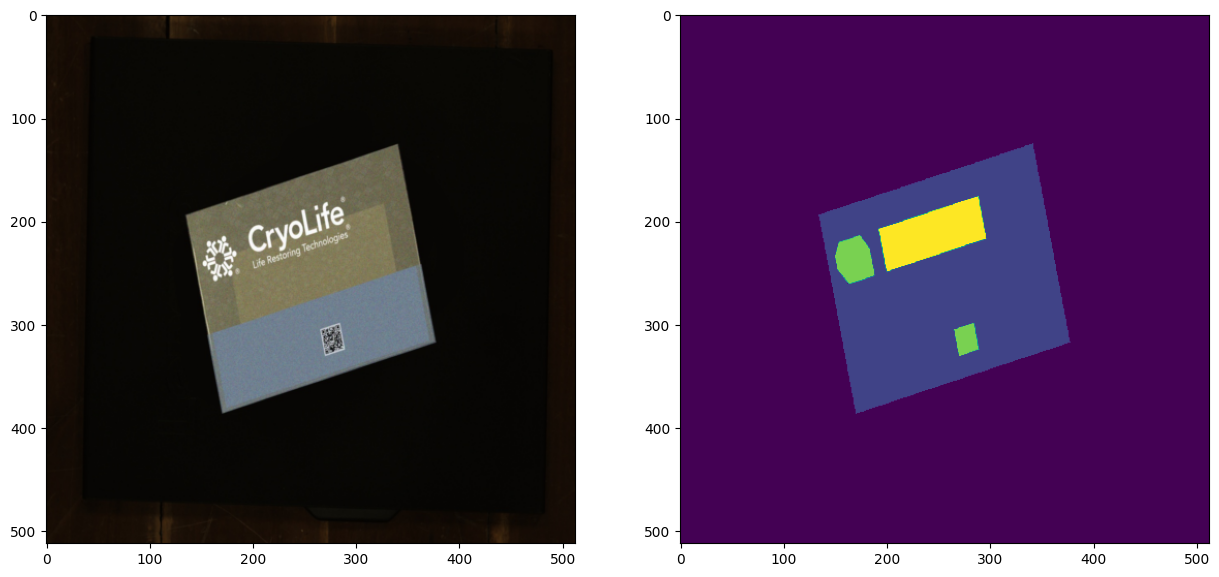

In [16]:
n = random.randint(0,len(tra_img_tensor_list))
torch_display2(n, tra_img_tensor_list, tra_mask_tensor_list)

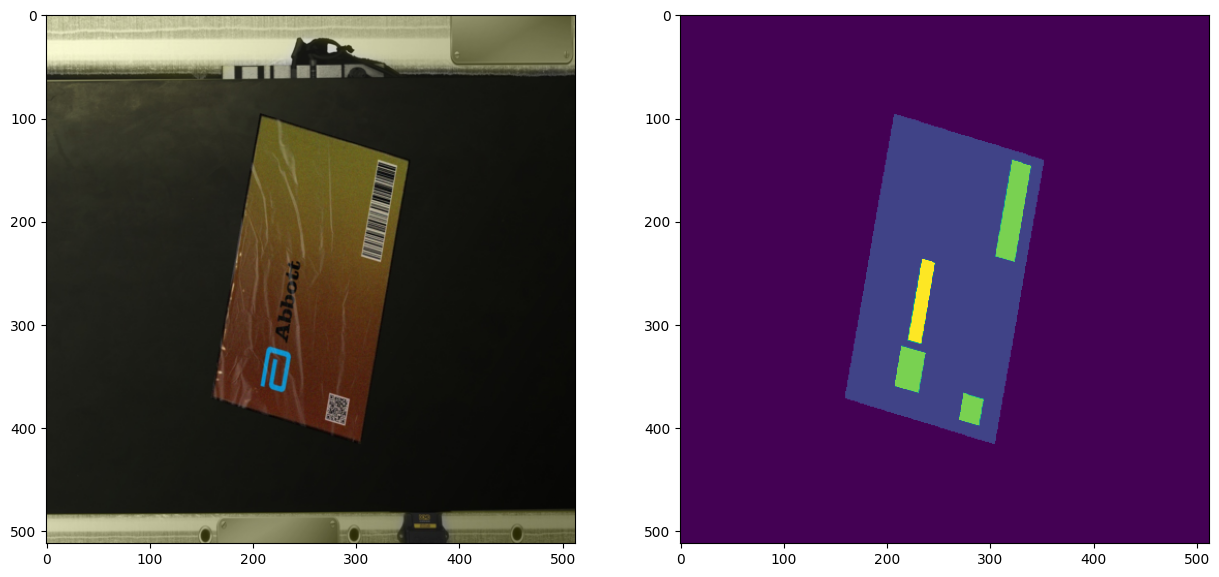

In [17]:
n = random.randint(0,len(val_img_tensor_list))
torch_display2(n, val_img_tensor_list, val_mask_tensor_list)